# GeneFormer

Geneformer is a foundational transformer model pretrained on a large-scale corpus of single cell transcriptomes to enable context-aware predictions in settings with limited data in network biology.

Here, you can use `omicverse.llm.SCLLMManager(model_type="geneformer")` to call this model directly.

Cite: Theodoris, C. V., Xiao, L., Chopra, A., Chaffin, M. D., Al Sayed, Z. R., Hill, M. C., ... & Ellinor, P. T. (2023). Transfer learning enables predictions in network biology. Nature, 618(7965), 616-624.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA H100 80GB HBM3
    • Total memory: 79.1 GB
    • Compute capability: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Load example datasets

For this tutorial, we use three batches from the NeurIPS 2021 single-cell competition dataset, which provides an excellent test case for batch integration and cell type annotation.

- s1d3: https://figshare.com/ndownloader/files/41932005
- s2d1: https://figshare.com/ndownloader/files/41932011
- s3d7: https://figshare.com/ndownloader/files/41932008

In [2]:
adata1=ov.read('data/neurips2021_s1d3.h5ad')
adata1.obs['batch']='s1d3'
adata2=ov.read('data/neurips2021_s2d1.h5ad')
adata2.obs['batch']='s2d1'
adata3=ov.read('data/neurips2021_s3d7.h5ad')
adata3.obs['batch']='s3d7'

In [3]:
adata=sc.concat([adata1,adata2,adata3],merge='same')
adata

AnnData object with n_obs × n_vars = 27423 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',
                       n_HVGs=3000,batch_key=None,target_sum=1e4)
adata

In [6]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata

View of AnnData object with n_obs × n_vars = 27423 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Download pre-trained model and dictionaries

The Geneformer model requires several components:
1. **Model weights**: Pre-trained transformer parameters (~420MB)
2. **Gene dictionaries**: Mapping between genes and tokens
3. **Gene median values**: For rank-based encoding
4. **Ensembl mappings**: Gene symbol to ID conversions

Download from HuggingFace: https://huggingface.co/ctheodoris/Geneformer/tree/main/Geneformer-V2-104M

In [6]:
#!/usr/bin/env python3
import os
import requests

urls = [
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/model.safetensors?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/config.json?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/generation_config.json?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/Geneformer-V2-104M/training_args.bin?download=true",
    
]

output_dir = "llm_model/models/geneformer/Geneformer-V2-104M"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    filename = url.split('?')[0].split('/')[-1]
    filepath = os.path.join(output_dir, filename)
    
    print(f"Downloading {filename} ...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(filepath, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Saved to {filepath}")

print("All files downloaded successfully.")


Saved to llm_model/models/geneformer/Geneformer-V2-104M/model.safetensors
Saved to llm_model/models/geneformer/Geneformer-V2-104M/config.json
Saved to llm_model/models/geneformer/Geneformer-V2-104M/generation_config.json
Saved to llm_model/models/geneformer/Geneformer-V2-104M/training_args.bin
All files downloaded successfully.


In [7]:
#!/usr/bin/env python3
import os
import requests

urls = [
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/ensembl_mapping_dict_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_median_dictionary_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/gene_name_id_dict_gc104M.pkl?download=true",
    "https://huggingface.co/ctheodoris/Geneformer/resolve/main/geneformer/token_dictionary_gc104M.pkl?download=true",
]

output_dir = "llm_model/models/geneformer"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    filename = url.split('?')[0].split('/')[-1]
    filepath = os.path.join(output_dir, filename)
    
    print(f"Downloading {filename} ...")
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    with open(filepath, "wb") as f:
        for chunk in resp.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"Saved to {filepath}")

print("All files downloaded successfully.")


Saved to llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl
Saved to llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl
Saved to llm_model/models/geneformer/gene_name_id_dict_gc104M.pkl
Saved to llm_model/models/geneformer/token_dictionary_gc104M.pkl
All files downloaded successfully.


## Initialize Geneformer V2 model

Geneformer V2 is the latest version with improved performance and a larger parameter count (104M). The model architecture is based on BERT with modifications for single-cell data.

In [4]:
manager = ov.llm.SCLLMManager(
    model_type='geneformer',
    model_version='V2',  
    device='cuda',
    
)
#analysis/omic_test/llm_model/Geneformer/geneformer/ensembl_mapping_dict_gc104M.pkl
manager.model.load_model(
    'llm_model/models/geneformer/Geneformer-V2-104M',
    gene_median_file='llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl',
    token_dictionary_file='llm_model/models/geneformer/token_dictionary_gc104M.pkl',
    gene_mapping_file='llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl'
)

[Loaded] Geneformer model initialized (version: V2)
[Loading] Loading Geneformer model
    Stored gene_median_file: llm_model/models/geneformer/gene_median_dictionary_gc104M.pkl
    Stored token_dictionary_file: llm_model/models/geneformer/token_dictionary_gc104M.pkl
    Stored gene_mapping_file: llm_model/models/geneformer/ensembl_mapping_dict_gc104M.pkl
[Loaded] Tokenizer initialized with external dictionary files
    Gene median: gene_median_dictionary_gc104M.pkl
    Token dictionary: token_dictionary_gc104M.pkl
[Loaded] Geneformer model loaded successfully
    Version: V2


## Zero-shot embedding generation

Generate embeddings using the pre-trained Geneformer model. 

The resulting 768-dimensional embeddings capture cellular states based on gene expression patterns:

In [15]:
embeddings = manager.get_embeddings(adata,max_ncells=100000)

[🔬Cells] Data Summary:
    Cells: 27,423
    Genes: 3,000
    Batches: 3
      s3d7: 11,230 cells
      s2d1: 10,258 cells
      s1d3: 5,935 cells
[Embedding] Starting get_embeddings...
    cells: 27,423
    genes: 3,000
[Preprocessing] Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
[Loaded] Normalized total counts
[Preprocessing] Preprocessing completed: 27423 cells × 3000 genes
[Predicting] Extracting cell embeddings with Geneformer...
[Preprocessing] Converting data to Geneformer format
    [Preprocessing] Preparing data for Geneformer tokenization
    [Preprocessing] Adding ensembl_id column to adata.var
    [Warning] Using gene symbols as ensembl_id (may cause filtering)
        [ℹ️Info] Geneformer works best with Ensembl gene IDs
    [ℹ️Info] Gene mapping analysis:
    [Preprocessing] Proactive gene symbol mapping...
    [Loaded] Successfully mapped 2767 genes to Ensembl IDs
    [Warning] Adding n_counts column to adata.obs...
    ✓ Added 

  0%|          | 0/138 [00:00<?, ?it/s]

[Loaded] Extracted embeddings from EmbExtractor: (27423, 768)
[✅Complete] get_embeddings completed successfully!
[✅Complete] Results summary:
    embedding_shape: (27423, 768)
    embedding_dim: 768


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


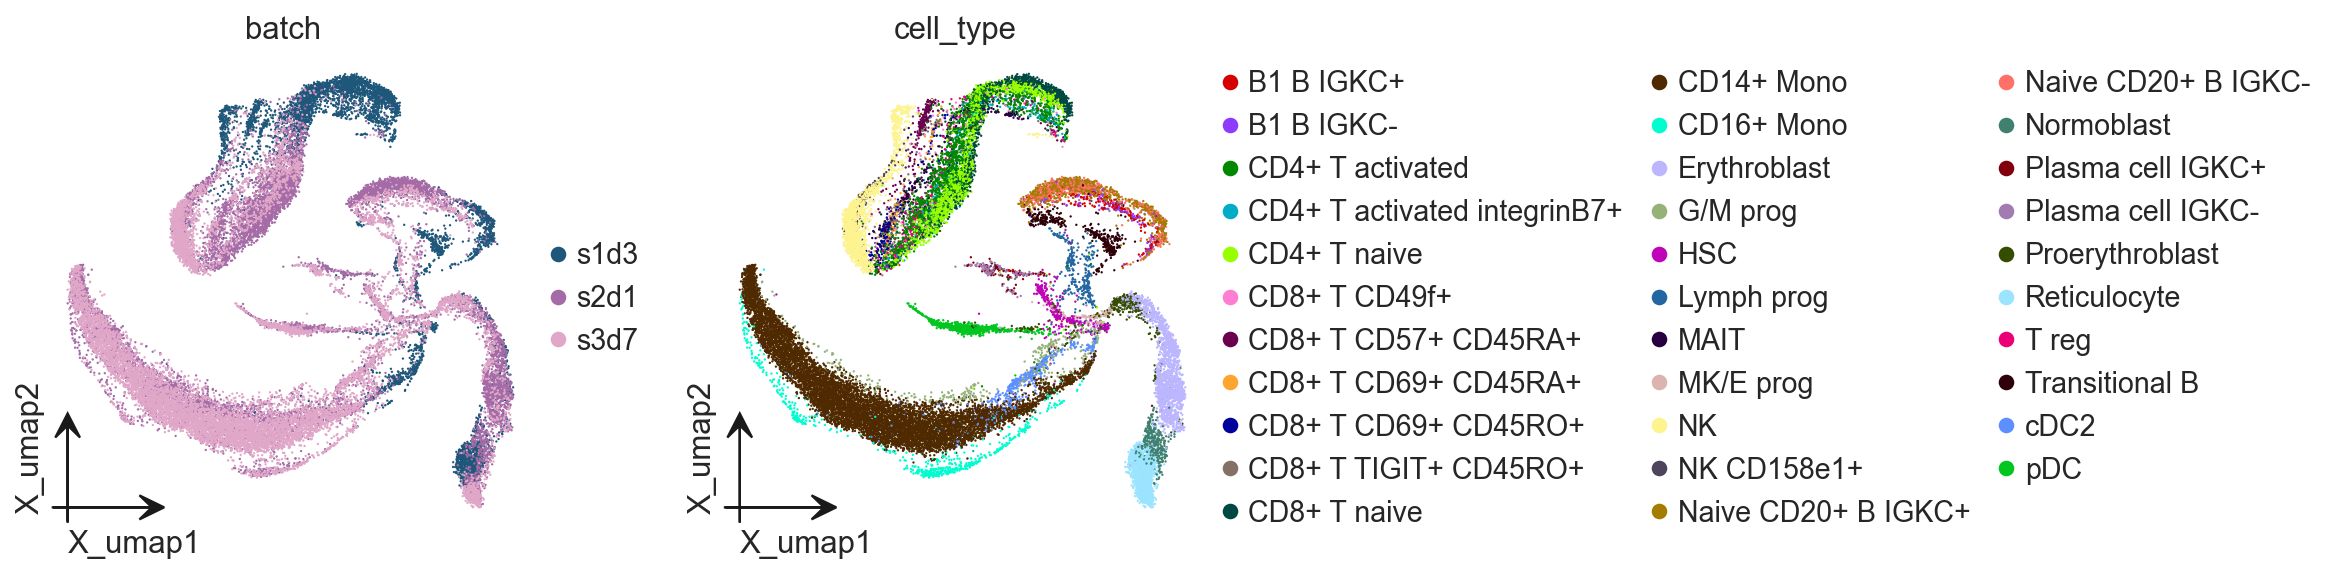

In [12]:
#adata.obsm['X_geneformer'] = df.loc[adata.obs.index,[f'emb_{i}' for i in range(0,768)]]
adata.obsm['X_geneformer'] = embeddings
sc.pp.neighbors(adata, use_rep='X_geneformer')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

## Fine-tuning for cell type classification

Fine-tune Geneformer on a reference dataset to adapt it for specific cell type recognition. The fine-tuning process updates the classification head while keeping most transformer layers frozen to prevent overfitting.


In [10]:
reference_adata=adata[adata.obs['batch']=='s1d3']

In [11]:
reference_adata

View of AnnData object with n_obs × n_vars = 5935 × 3000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'status', 'status_args', 'REFERENCE_MANU'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [12]:
reference_adata.obs['celltype']=reference_adata.obs['cell_type'].copy()

In [16]:
fine_tune_results = manager.model.fine_tune(
    train_adata=reference_adata,
    epochs=10,           # 
    batch_size=32,       # 
    lr=1e-4,            # 
)

🔧 Fine-tuning Geneformer for annotation task...
Cell types detected: ['CD14+ Mono', 'CD8+ T naive', 'NK', 'T reg', 'CD8+ T CD57+ CD45RA+', 'Transitional B', 'Lymph prog', 'Naive CD20+ B IGKC+', 'Normoblast', 'Reticulocyte', 'CD4+ T naive', 'CD4+ T activated', 'CD8+ T TIGIT+ CD45RO+', 'B1 B IGKC+', 'CD4+ T activated integrinB7+', 'Erythroblast', 'MAIT', 'B1 B IGKC-', 'CD8+ T CD49f+', 'Naive CD20+ B IGKC-', 'G/M prog', 'Proerythroblast', 'HSC', 'CD16+ Mono', 'cDC2', 'CD8+ T CD69+ CD45RO+', 'pDC', 'CD8+ T CD69+ CD45RA+', 'Plasma cell IGKC+', 'MK/E prog']
[Preprocessing] Creating tokenized dataset
    [Preprocessing] Preparing data for Geneformer tokenization
    [Preprocessing] Adding ensembl_id column to adata.var
    [Warning] Using gene symbols as ensembl_id (may cause filtering)
        [ℹ️Info] Geneformer works best with Ensembl gene IDs
    [ℹ️Info] Gene mapping analysis:
    [Preprocessing] Proactive gene symbol mapping...
    [Loaded] Successfully mapped 2767 genes to Ensembl IDs


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at llm_model/models/geneformer/Geneformer-V2-104M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


    [Loaded] Tokenized 5935 cells
[Preprocessing] Adding labels and splitting dataset...
    Using cell_barcode mapping for labels...
    Train set: 5342 cells
    Eval set: 593 cells


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


    [Loaded] Model initialized with 30 classes
[Training] Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.830700,0.659676,0.833052,0.422297
2,0.410600,0.900503,0.726813,0.485091
3,0.682200,0.501471,0.871838,0.618438
4,0.309900,0.338666,0.900506,0.678833
5,0.523200,0.353199,0.895447,0.694306
6,0.209100,0.304860,0.913997,0.697800
7,0.137500,0.393189,0.885329,0.688280
8,0.100900,0.409528,0.905565,0.722270
9,0.132900,0.380685,0.885329,0.720899
10,0.083000,0.373825,0.903879,0.756619


[✅Complete] Fine-tuning completed
    [Loaded] Extracted BERT base model from classification model


### Batch integration with fine-tuned model

After fine-tuning, we perform batch integration to remove technical variations while preserving biological differences. This critical step ensures that cells from different batches can be properly compared and analyzed together.

In [17]:
zero_shot_results = manager.model.integrate(
    adata,
    batch_key="batch",
    correction_method="mnn",
    max_ncells=100000
)
adata.obsm['X_geneformer_fine'] = zero_shot_results['embeddings']

[Preprocessing] Performing batch integration with Geneformer embeddings...
[🔬Cells] Data Summary:
    Cells: 27,423
    Genes: 3,000
    Batches: 3
      s3d7: 11,230 cells
      s2d1: 10,258 cells
      s1d3: 5,935 cells
[Embedding] Starting get_embeddings...
    cells: 27,423
    genes: 3,000
[Preprocessing] Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
[Loaded] Normalized total counts
[Preprocessing] Preprocessing completed: 27423 cells × 3000 genes
[Predicting] Extracting cell embeddings with Geneformer...
[Preprocessing] Converting data to Geneformer format
    [Preprocessing] Preparing data for Geneformer tokenization
    [Preprocessing] Adding ensembl_id column to adata.var
    [Warning] Using gene symbols as ensembl_id (may cause filtering)
        [ℹ️Info] Geneformer works best with Ensembl gene IDs
    [ℹ️Info] Gene mapping analysis:
    [Preprocessing] Proactive gene symbol mapping...
    [Loaded] Successfully mapped 2767 genes to En

  0%|          | 0/138 [00:00<?, ?it/s]

[Loaded] Extracted embeddings from EmbExtractor: (27423, 768)
[✅Complete] get_embeddings completed successfully!
[✅Complete] Results summary:
    embedding_shape: (27423, 768)
    embedding_dim: 768
    Found 3 batches with distribution: [ 5935 10258 11230]
    Using raw Geneformer embeddings
[Loaded] Integration completed using mnn method


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


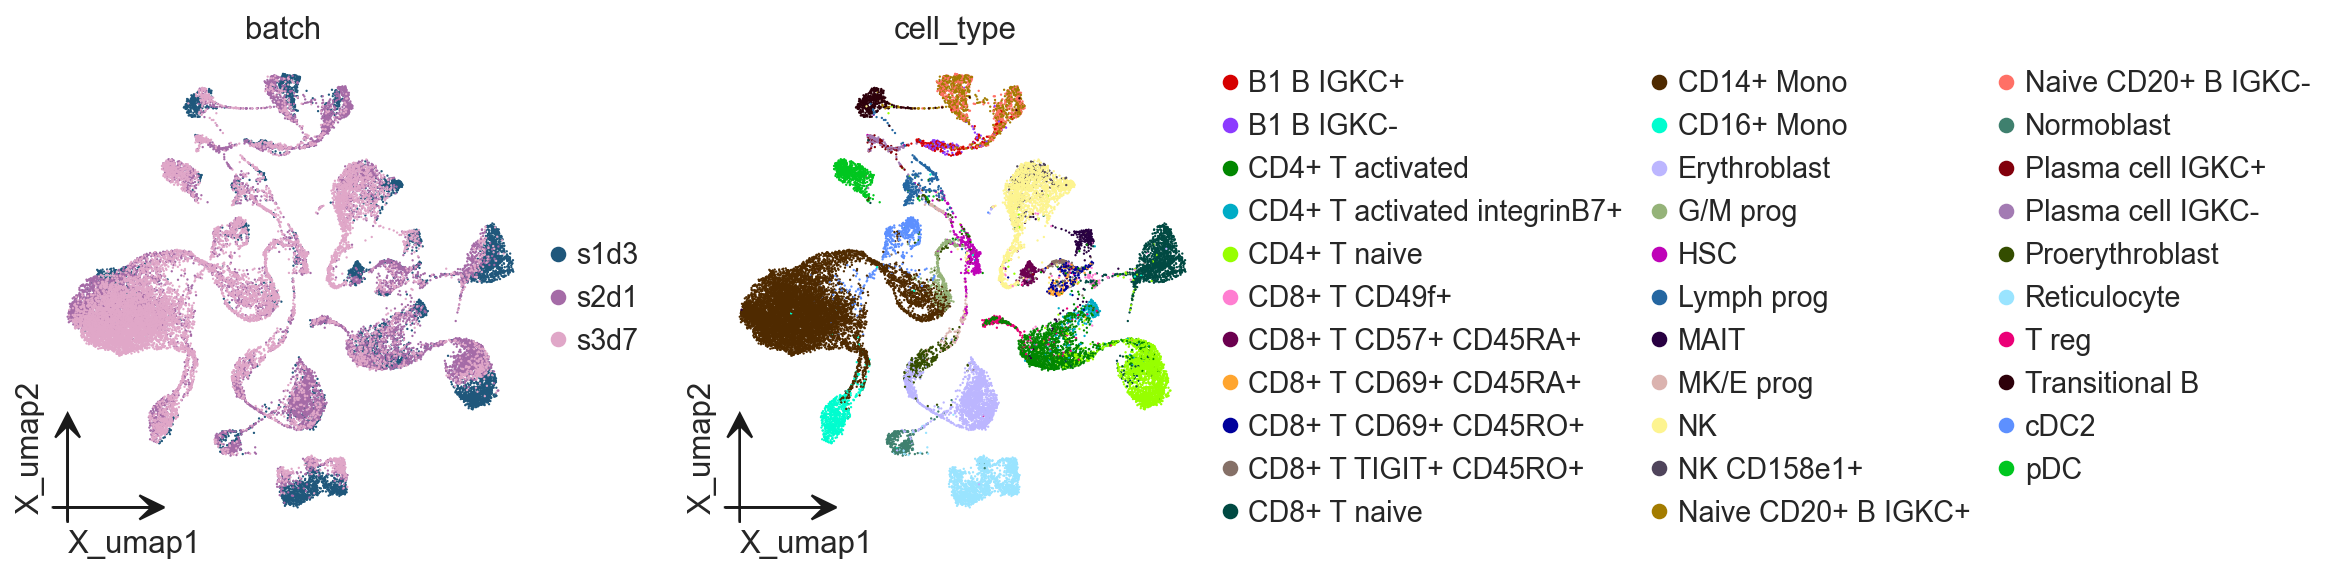

In [18]:
sc.pp.neighbors(adata, use_rep='X_geneformer_fine')
sc.tl.umap(adata)
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'cell_type']
)

### Cell type annotation with fine-tuned model

The fine-tuned GeneFormer model can now predict cell types for all cells in the dataset, including those from batches not used in training. This demonstrates the model's ability to generalize learned patterns to new data while leveraging the improved discrimination capability gained through fine-tuning.

In [18]:
results_anno = manager.model.predict(
    adata,
    task="annotation",
    max_ncells=100000
)

[Preprocessing] Preprocessing data for Geneformer...
normalizing counts per cell
    finished (0:00:00)
[Loaded] Normalized total counts
[Preprocessing] Preprocessing completed: 27423 cells × 3000 genes
[Predicting] Predicting cell types with Geneformer...
[Preprocessing] Preparing data for prediction
    [Preprocessing] Preparing data for Geneformer tokenization
    [Preprocessing] Adding ensembl_id column to adata.var
    [Warning] Using gene symbols as ensembl_id (may cause filtering)
        [ℹ️Info] Geneformer works best with Ensembl gene IDs
    [ℹ️Info] Gene mapping analysis:
    [Preprocessing] Proactive gene symbol mapping...
    [Loaded] Successfully mapped 2767 genes to Ensembl IDs
    [Warning] Adding n_counts column to adata.obs...
    ✓ Added n_counts: mean=9915.1, std=42.4
    [Preprocessing] Adding cell_barcode column to preserve cell identity...
    ✓ Added cell_barcode column with 27423 barcodes
[Preprocessing] Tokenizing data for Geneformer
    [Preprocessing] Attemp

In [20]:
adata.obs['predicted_celltype'] = results_anno['predicted_celltypes']
adata.obs['predicted_celltype_id'] = results_anno['predictions']

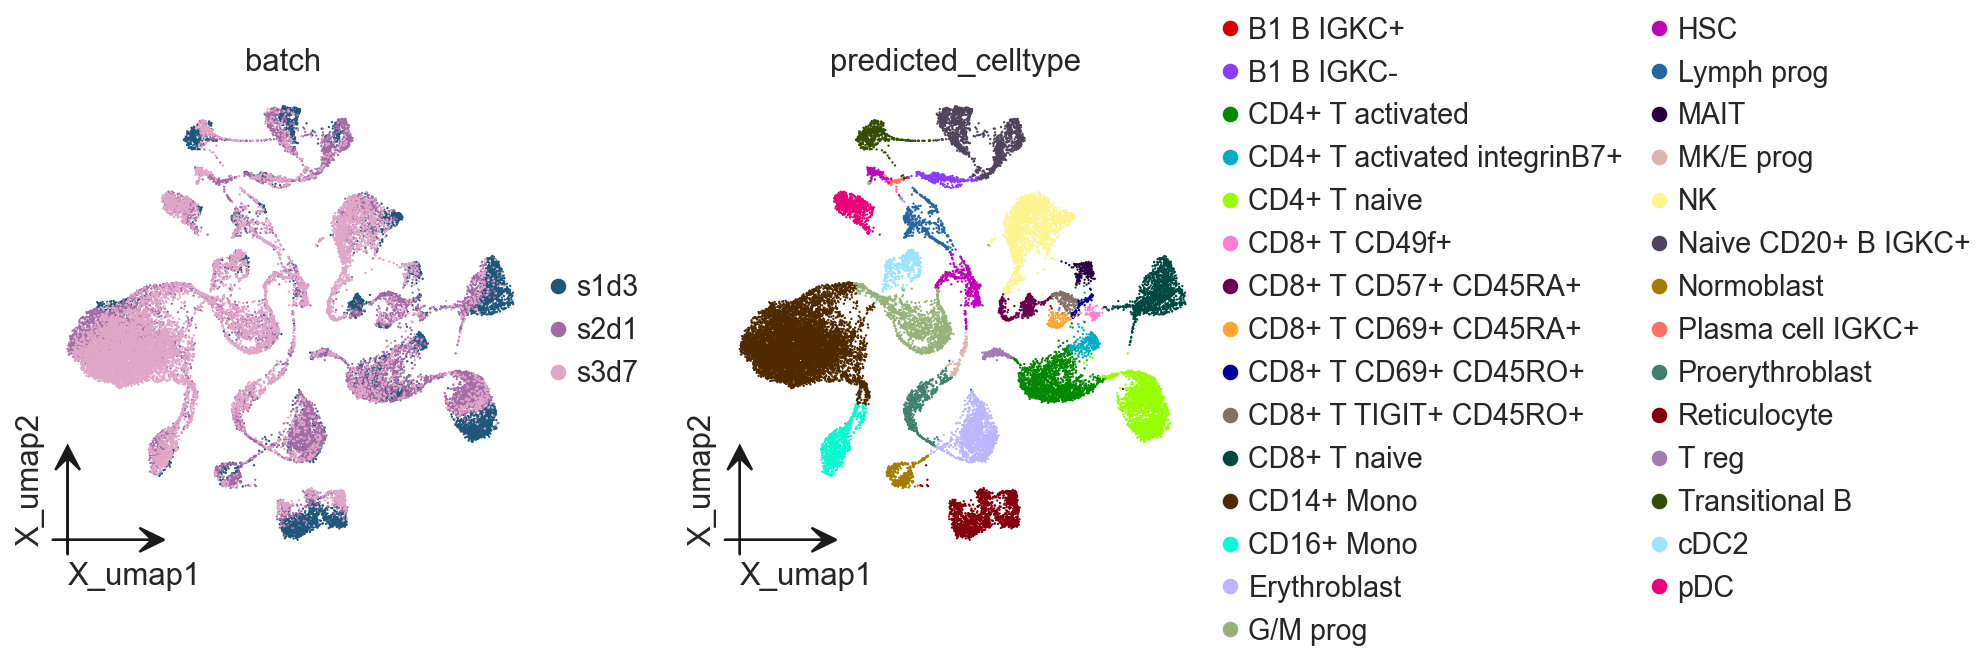

In [21]:
ov.pl.embedding(
    adata, 
    basis='X_umap',
    color=['batch', 'predicted_celltype']
)